In [39]:
import json, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Model
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Concatenate
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.utils import class_weight
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#use cleaned data
dataset=pd.DataFrame()
dataset = pd.read_pickle('/content/drive/MyDrive/dataset_prepro.pickle')

In [4]:
label_list = [ "Electricity",
        "Storm",
        "WaterDamage",
        "Other_DamageType",
        "CracksAndTears",
        "GlassBreakage",
        "Collision",
        "Burglary",
        "Fire_Smoke_Explosion",
        "Theft",
        "Environment_OilFuel",
        "Flooding",]
dataset = dataset[dataset["labels.damage_type"].isin(label_list)]

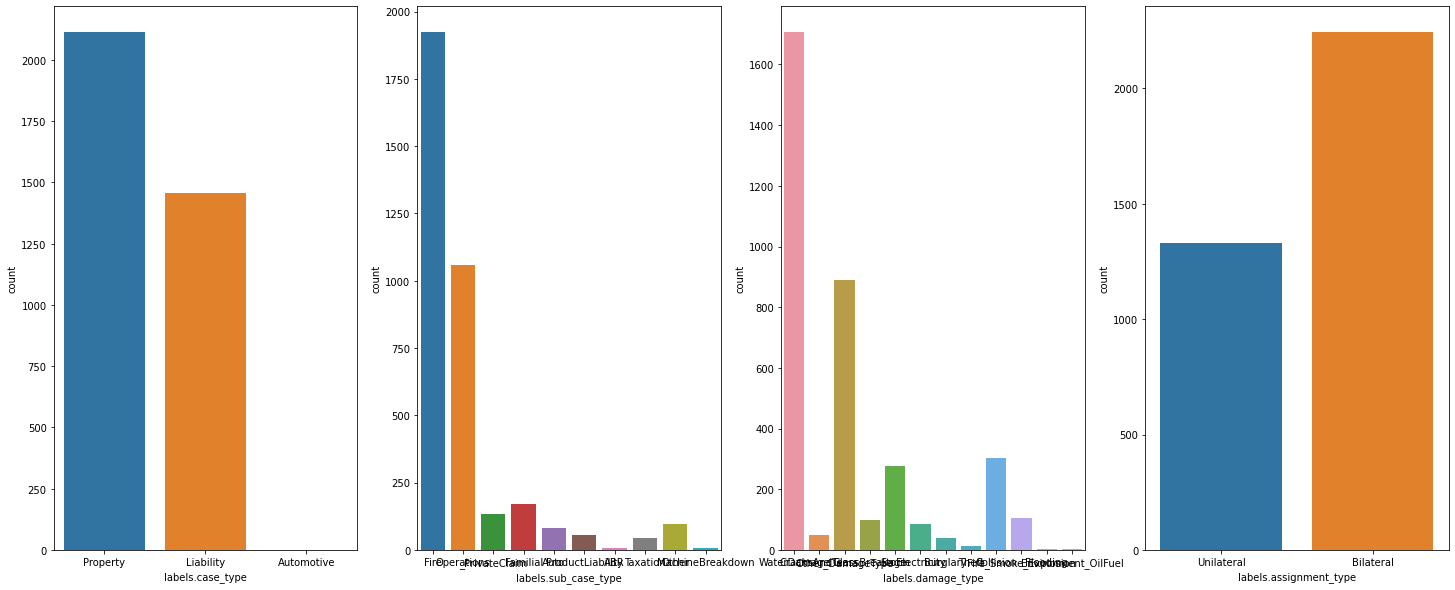

In [5]:
fig, ax = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(10)
sns.countplot(x='labels.case_type',data=dataset,ax=ax[0])
sns.countplot(x='labels.sub_case_type',data=dataset,ax=ax[1])
sns.countplot(x='labels.damage_type',data=dataset,ax=ax[2])
sns.countplot(x='labels.assignment_type',data=dataset,ax=ax[3])

In [6]:
n=500
dataset=dataset.set_index(['language', 'mail_content','labels.assignment_type','labels.case_type','labels.sub_case_type','labels.damage_type','attachments_filename'])['attachments_content'].str.split().apply(
               lambda x: pd.Series([' '.join(x[i:i+n]) for i in range(0, len(x), n)])
            ).stack().reset_index().drop('level_7', 1)
dataset.columns = [*dataset.columns[:-1], 'attachments_content']

In [7]:
dataset

,language,mail_content,labels.assignment_type,labels.case_type,labels.sub_case_type,labels.damage_type,attachments_filename,attachments_content
0,fr_BE,annexe transmettons document concernant missi...,Unilateral,Property,Fire,WaterDamage,MISSION_ASSIGNEMENT,blvd roi ii bic tva rpm entreprise agr nationa...
1,nl_BE,bijlage wij document betrekking opdracht toev...,Bilateral,Liability,Operations,CracksAndTears,MISSION_ASSIGNEMENT foto 2021-00053-HEFI dd 14...,nv koning bic btw verzekeringsmaatschappij toe...
2,nl_BE,bijlage wij document betrekking opdracht toev...,Bilateral,Liability,Operations,CracksAndTears,MISSION_ASSIGNEMENT foto 2021-00053-HEFI dd 14...,per max uur per per per zuivere onstoffelijke ...
3,nl_BE,bijlage wij document betrekking opdracht toev...,Bilateral,Liability,Operations,CracksAndTears,MISSION_ASSIGNEMENT foto 2021-00053-HEFI dd 14...,wegvallen herziening opzeg dient per aangeteke...
4,nl_BE,sans mevrouw contacteren verzekeraar bijlage ...,Unilateral,Property,Fire,WaterDamage,Polis 1213534_12-29-2020_0240361364 VIVIUM PR ...,historiek num contract ris schade num beschrij...
...,...,...,...,...,...,...,...,...
10108,fr_BE,annexe transmettons document concernant missi...,Bilateral,Liability,Operations,Collision,Devis Watremez.les maçons qui avaient créé le ...,montant franchises ventuelles clauses estimati...
10109,fr_BE,annexe transmettons document concernant missi...,Bilateral,Liability,Operations,Collision,Devis Watremez.les maçons qui avaient créé le ...,autre compagnie entreprise plus sinistre rc co...
10110,fr_BE,annexe transmettons document concernant missi...,Bilateral,Liability,Operations,Collision,Devis Watremez.les maçons qui avaient créé le ...,occupation passe jours cours contrat preneur a...
10111,nl_BE,bijlage wij document betrekking opdracht toev...,Unilateral,Property,Fire,Storm,MISSION_ASSIGNEMENT bestek cl Foto's (2).- vo...,nv koning bic btw verzekeringsmaatschappij toe...


In [8]:
y=dataset[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X=dataset.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type'], axis=1)

In [9]:
X=X.drop(['language'],axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8090, 3) (8090, 4)
(2023, 3) (2023, 4)


In [12]:
X_test_original=X_test

In [13]:
dataset.attachments_content.str.split().str.len().max()

500

In [14]:
#Max number van woorden
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100

In [15]:
#mail_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['mail_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_mc = tokenizer.texts_to_sequences(X_train['mail_content'].values)
X_train_mc = pad_sequences(X_train_mc,maxlen=400)
print('Shape of data X_train_mc:', X_train_mc.shape)

X_test_mc = tokenizer.texts_to_sequences(X_test['mail_content'].values)
X_test_mc = pad_sequences(X_test_mc,maxlen=400)
print('Shape of data X_train_mc:', X_test_mc.shape)

Found 561 unique tokens.
Shape of data X_train_mc: (8090, 400)
Shape of data X_train_mc: (2023, 400)


In [16]:
#attachments_filename Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_filename'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_af = tokenizer.texts_to_sequences(X_train['attachments_filename'].values)
X_train_af = pad_sequences(X_train_af,maxlen=200)
print('Shape of data X_train_af:', X_train_af.shape)

X_test_af = tokenizer.texts_to_sequences(X_test['attachments_filename'].values)
X_test_af = pad_sequences(X_test_af,maxlen=200)
print('Shape of data X_test_af:', X_test_af.shape)

Found 15566 unique tokens.
Shape of data X_train_af: (8090, 200)
Shape of data X_test_af: (2023, 200)


In [17]:
#attachments_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_ac = tokenizer.texts_to_sequences(X_train['attachments_content'].values)
X_train_ac = pad_sequences(X_train_ac,maxlen=500)
print('Shape of data X_train_ac:', X_train_ac.shape)

X_test_ac = tokenizer.texts_to_sequences(X_test['attachments_content'].values)
X_test_ac = pad_sequences(X_test_ac,maxlen=500)
print('Shape of data X_train_ac:', X_test_ac.shape)

Found 43261 unique tokens.
Shape of data X_train_ac: (8090, 500)
Shape of data X_train_ac: (2023, 500)


In [18]:
#One-hot multi output
y1_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y1_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y2_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y2_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y3_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y3_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y4_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)
y4_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)

y1_train=y1_train.combine_first(pd.get_dummies(y_train[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Train:', y1_train.shape)
y1_test=y1_test.combine_first(pd.get_dummies(y_test[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Test:', y1_test.shape)

y2_train=y2_train.combine_first(pd.get_dummies(y_train[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Train:', y2_train.shape)
y2_test=y2_test.combine_first(pd.get_dummies(y_test[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Test:', y2_test.shape)

y3_train=y3_train.combine_first(pd.get_dummies(y_train[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Train:', y3_train.shape)
y3_test=y3_test.combine_first(pd.get_dummies(y_test[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Test:', y3_test.shape)

y4_train=y4_train.combine_first(pd.get_dummies(y_train[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Train:', y4_train.shape)
y4_test=y4_test.combine_first(pd.get_dummies(y_test[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Test:', y4_test.shape)

Shape of label tensor Y1 Train: (8090, 2)
Shape of label tensor Y1 Test: (2023, 2)
Shape of label tensor Y2 Train: (8090, 3)
Shape of label tensor Y2 Test: (2023, 3)
Shape of label tensor Y3 Train: (8090, 10)
Shape of label tensor Y3 Test: (2023, 10)
Shape of label tensor Y4 Train: (8090, 12)
Shape of label tensor Y4 Test: (2023, 12)


# Models

In [19]:
#Optimizer
opt = tf.keras.optimizers.Adam(lr=0.0001)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

#checkpoint
checkpoint_path='/content/drive/MyDrive/LSTM_bestmodel.h5'
mc=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)

#Model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

# model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.5)(embeding_mc)
o_mc=LSTM(64, dropout=0.5)(s_mc)
s_af=SpatialDropout1D(0.5)(embeding_af)
o_af=LSTM(64, dropout=0.5)(s_af)
s_ac=SpatialDropout1D(0.5)(embeding_ac)
o_ac=LSTM(64, dropout=0.5)(s_ac)

concat_layer = Concatenate()([o_mc, o_af,o_ac])
r=Dense(32, activation='relu')(concat_layer)
o1=Dense(2, activation='softmax',name='assignment_type')(r)
o2=Dense(3, activation='softmax',name='case_type')(r)
o3=Dense(10, activation='softmax',name='sub_case_type')(r)
o4=Dense(12, activation='softmax',name='damage_type')(r)


epochs = 400
batch_size = 128

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[o1, o2, o3, o4])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac],[y1_train,y2_train,y3_train,y4_train],epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[es,mc])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/400
45/45 [==============================] - 39s 268ms/step - loss: 6.5459 - assignment_type_loss: 0.6906 - case_type_loss: 1.0802 - sub_case_type_loss: 2.2938 - damage_type_loss: 2.4813 - assignment_type_accuracy: 0.5601 - case_type_accuracy: 0.5869 - sub_case_type_accuracy: 0.1967 - damage_type_accuracy: 0.0967 - val_loss: 6.4065 - val_assignment_type_loss: 0.6769 - val_case_type_loss: 1.0343 - val_sub_case_type_loss: 2.2493 - val_damage_type_loss: 2.4460 - val_assignment_type_accuracy: 0.6679 - val_case_type_accuracy: 0.6135 - val_sub_case_type_accuracy: 0.5426 - val_damage_type_accuracy: 0.5019
Epoch 2/400
45/45 [==============================] - 10s 227ms/step - loss: 6.2969 - assignment_type_loss: 0.6709 - case_type_loss: 0.9994 - sub_case_type_loss: 2.2133 - damage_type_loss: 2.4133 - assignment_type_accuracy: 0.6564 - case_type_accuracy: 0.5948 - sub_case_type_accuracy: 0.5279 - damage_type_accuracy: 0.4669 - val_loss: 5.2398 - val_assignment_type_loss: 0.6437 - val_cas

## Evaluatie

In [20]:
score = model.evaluate(x=[X_test_mc,X_test_af,X_test_ac], y=[y1_test, y2_test, y3_test, y4_test], verbose=1)
print("Loss:", score[0])
print("Test Accuracy:", score[1])

64/64 [==============================] - 2s 25ms/step - loss: 1.6146 - assignment_type_loss: 0.2415 - case_type_loss: 0.1183 - sub_case_type_loss: 0.4862 - damage_type_loss: 0.7686 - assignment_type_accuracy: 0.9377 - case_type_accuracy: 0.9733 - sub_case_type_accuracy: 0.8927 - damage_type_accuracy: 0.8117
Loss: 1.6146091222763062
Test Accuracy: 0.24150802195072174


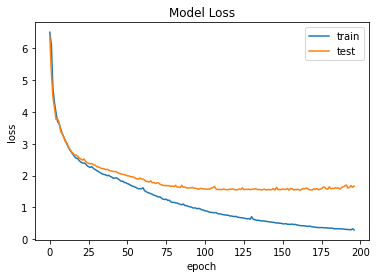

In [21]:
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

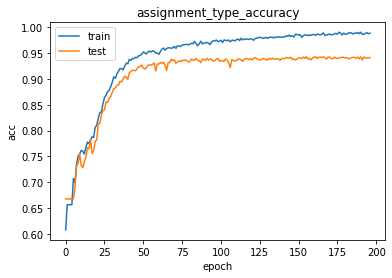

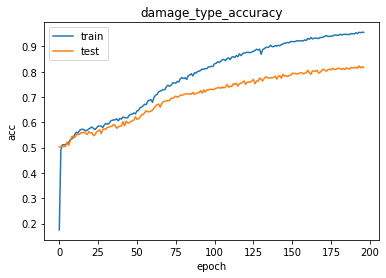

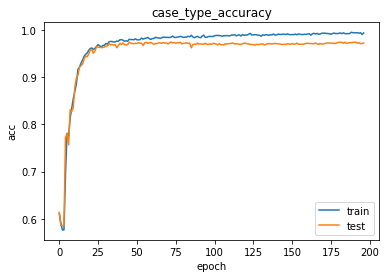

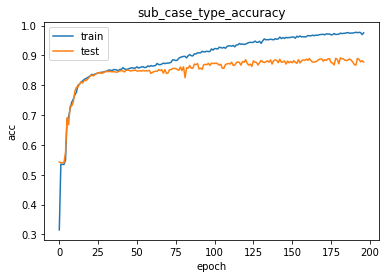

In [22]:
plt.title('assignment_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_accuracy'], label='train')
plt.plot(history.history['val_assignment_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_accuracy'], label='train')
plt.plot(history.history['val_damage_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_accuracy'], label='train')
plt.plot(history.history['val_case_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_accuracy'], label='train')
plt.plot(history.history['val_sub_case_type_accuracy'], label='test')
plt.legend()
plt.show();

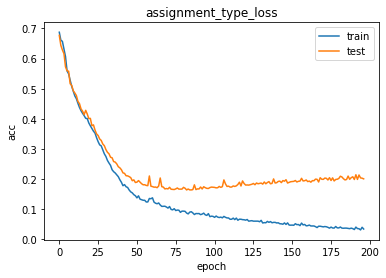

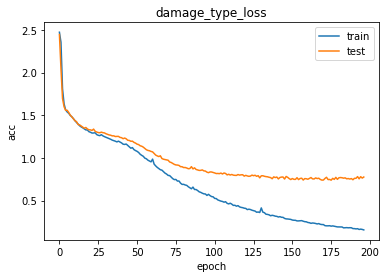

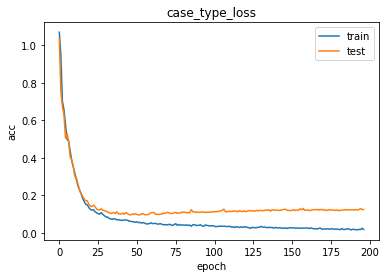

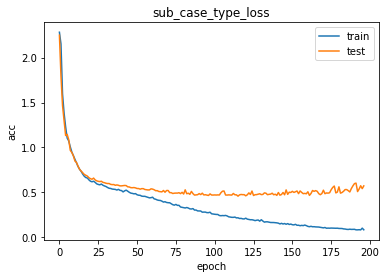

In [23]:
plt.title('assignment_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_loss'], label='train')
plt.plot(history.history['val_assignment_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_loss'], label='train')
plt.plot(history.history['val_damage_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('case_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_loss'], label='train')
plt.plot(history.history['val_case_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_loss'], label='train')
plt.plot(history.history['val_sub_case_type_loss'], label='test')
plt.legend()
plt.show();

In [40]:
# Testing with the test set
# Loading the the best performing model
model.load_weights(checkpoint_path)
y1_pred,y2_pred,y3_pred,y4_pred = model.predict([X_test_mc,X_test_af,X_test_ac])

In [41]:
predictions_assign=pd.DataFrame(columns=y1_train.columns, data=(y1_pred>0.5).astype(np.int))
predictions_case=pd.DataFrame(columns=y2_train.columns, data=(y2_pred>0.5).astype(np.int))
predictions_sub_case=pd.DataFrame(columns=y3_train.columns, data=(y3_pred>0.5).astype(np.int))
predictions_damage=pd.DataFrame(columns=y4_train.columns, data=(y4_pred>0.5).astype(np.int))
result = pd.concat([X_test_original,predictions_assign, predictions_case,predictions_sub_case,predictions_damage,y_test], axis=1, join="inner")

In [42]:
result.head(10)

,mail_content,attachments_filename,attachments_content,labels.assignment_type_Bilateral,labels.assignment_type_Unilateral,labels.case_type_Automotive,labels.case_type_Liability,labels.case_type_Property,labels.sub_case_type_ABR,labels.sub_case_type_Auto,labels.sub_case_type_Familial,labels.sub_case_type_Fire,labels.sub_case_type_MachineBreakdown,labels.sub_case_type_Operations,labels.sub_case_type_Other,labels.sub_case_type_ProductLiability,labels.sub_case_type_Taxation,labels.sub_case_type__PrivateClaim,labels.damage_type_Burglary,labels.damage_type_Collision,labels.damage_type_CracksAndTears,labels.damage_type_Electricity,labels.damage_type_Environment_OilFuel,labels.damage_type_Fire_Smoke_Explosion,labels.damage_type_Flooding,labels.damage_type_GlassBreakage,labels.damage_type_Other_DamageType,labels.damage_type_Storm,labels.damage_type_Theft,labels.damage_type_WaterDamage,labels.case_type,labels.sub_case_type,labels.damage_type,labels.assignment_type
598,sans mevrouw contacteren verzekeraar bijlage ...,VIVIUM GL C302100535 C36 Inspectie - MS 2021-0...,opdracht materiele schade zetel expert experts...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Liability,Operations,Other_DamageType,Bilateral
1509,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT Exp CED vraagt of wij exp ...,verzekerde blijven hiervan afwachting vriendel...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Liability,Operations,WaterDamage,Bilateral
915,bijlage wij document betrekking opdracht toev...,VIVIUM igbst aanstelling CED Property MISSION_...,toevoegen wij behouden steeds recht mogelijkhe...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,Liability,Familial,WaterDamage,Bilateral
1308,bijlage wij document betrekking opdracht toev...,factuur lekzoed foto schade lekzoek foto lek n...,zodat contract aangepast nieuwe situatie inspe...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Property,Fire,WaterDamage,Unilateral
1118,annexe transmettons document concernant missi...,in mail décla NoName MISSION_ASSIGNEMENT copi...,date februari subject ext acp trouverez annexe...,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Liability,ABR,WaterDamage,Bilateral
1422,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT lekzoekverslag Bestandenbl...,alle beoefenen pagina contract nr schade bijzo...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Property,Fire,WaterDamage,Bilateral
982,annexe transmettons document concernant missi...,2020-0376- NOYELLE- ZSN202011931 MISSION_ASSIG...,gestion sinistre date november subject madame ...,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Property,Fire,WaterDamage,Unilateral
133,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT Bestandenblad Weemaes Glas...,gewone verblijfplaats uitbreiding toepassing m...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Property,Fire,GlassBreakage,Unilateral
1382,mevrouw contacteren verzekeraar bijlage vindt...,1138199_12-15-2020_2724556 1463581_02-03-2021_...,omstandigheden zie mail klant living komt prob...,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Liability,Operations,WaterDamage,Bilateral
1826,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT foto vochtschade bestek 1 ...,schade afschaffing toepassing wanneer ontoerei...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Property,Fire,WaterDamage,Unilateral


# Test evaluatie

In [43]:
#assignment_type
y1_pred = (y1_pred > 0.5) 
y1_pred=np.argmax(y1_pred, axis=1)
y_test_cat=pd.Categorical(y_test['labels.assignment_type'])
y_test_cat=y_test_cat.codes
#case_type
y2_pred = (y2_pred > 0.5) 
y2_pred=np.argmax(y2_pred, axis=1)
y2_test_cat=pd.Categorical(y_test['labels.case_type'])
y2_test_cat=y2_test_cat.codes
#sub_case_type
y3_pred = (y3_pred > 0.5) 
y3_pred=np.argmax(y3_pred, axis=1)
y3_test_cat=pd.Categorical(y_test['labels.sub_case_type'])
y3_test_cat=y3_test_cat.codes
#damage_type
y4_pred = (y4_pred > 0.5) 
y4_pred=np.argmax(y4_pred, axis=1)
y4_test_cat=pd.Categorical(y_test['labels.damage_type'])
y4_test_cat=y4_test_cat.codes

['Property', 'Liability', 'Property', 'Liability', 'Liability', ..., 'Liability', 'Property', 'Liability', 'Property', 'Liability']
Length: 2023
Categories (3, object): ['Automotive', 'Liability', 'Property']

In [62]:
cf = confusion_matrix(y_test_cat,y1_pred.astype(int),labels=[1,0])
cr= classification_report(y_test_cat,y1_pred.astype(int))
print("assignment_type")
print(cr)
print(cf)
print(y_test['labels.assignment_type'].unique())

assignment_type
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1319
           1       0.92      0.90      0.91       704

    accuracy                           0.94      2023
   macro avg       0.93      0.93      0.93      2023
weighted avg       0.94      0.94      0.94      2023

[[ 635   69]
 [  54 1265]]
['Bilateral' 'Unilateral']


In [63]:
cf = confusion_matrix(y2_test_cat,y2_pred.astype(int))
cr= classification_report(y2_test_cat,y2_pred.astype(int))
print("case_type")
print(cr)
print(cf)
print(y_test['labels.case_type'].unique())

case_type
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.97      0.96      0.96       801
           2       0.97      0.98      0.98      1221

    accuracy                           0.97      2023
   macro avg       0.65      0.65      0.65      2023
weighted avg       0.97      0.97      0.97      2023

[[   0    0    1]
 [   0  769   32]
 [   0   25 1196]]
['Property' 'Liability' 'Automotive']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
cf = confusion_matrix(y3_test_cat,y3_pred.astype(int))
cr= classification_report(y3_test_cat,y3_pred.astype(int))
print("case_type")
print(cr)
print(cf)
print(y_test['labels.sub_case_type'].unique())

case_type
              precision    recall  f1-score   support

           0       0.05      0.80      0.10         5
           1       0.81      0.32      0.46        41
           2       0.68      0.40      0.51        89
           3       0.97      0.98      0.97      1107
           4       0.00      0.00      0.00         7
           5       0.89      0.93      0.91       591
           6       0.44      0.26      0.33        42
           7       0.77      0.77      0.77        31
           8       0.40      0.14      0.21        14
           9       0.75      0.62      0.68        96

    accuracy                           0.88      2023
   macro avg       0.58      0.52      0.49      2023
weighted avg       0.89      0.88      0.88      2023

[[   4    0    0    1    0    0    0    0    0    0]
 [   9   13    0    6    0   11    1    0    1    0]
 [   5    1   36    1    0   43    0    0    0    3]
 [  12    0    1 1083    0    2    1    4    1    3]
 [   1    1    0   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
cf = confusion_matrix(y4_test_cat,y4_pred.astype(int))
cr= classification_report(y4_test_cat,y4_pred.astype(int))
print("damage_type")
print(cr)
print(cf)
print(y_test['labels.damage_type'].unique())

damage_type
              precision    recall  f1-score   support

           0       0.04      0.58      0.07        19
           1       0.73      0.44      0.55       181
           2       0.82      0.57      0.68        40
           3       0.87      0.70      0.78        57
           4       0.00      0.00      0.00         4
           5       0.45      0.09      0.15        56
           6       0.00      0.00      0.00         2
           7       0.70      0.13      0.23        52
           8       0.80      0.87      0.83       470
           9       0.68      0.45      0.54       127
          10       0.00      0.00      0.00        11
          11       0.95      0.89      0.92      1004

    accuracy                           0.75      2023
   macro avg       0.50      0.39      0.40      2023
weighted avg       0.83      0.75      0.78      2023

[[ 11   0   0   0   0   1   0   2   0   4   0   1]
 [ 51  80   2   4   0   0   0   0  39   3   0   2]
 [  7   4  23   0  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
